# Review : Bayesian Method of Marketing Mix Modeling (MMM) with Carry Over and Shape Effect

Marketing Mix Modeling is a technique used to assess the impact of various media expenditures on sales performance. By understanding the effectiveness of each media channel, companies can optimize their spending strategies. Traditionally, these models relied on linear regression to analyze the relationship between media spending and sales. However, there is a growing consensus among marketers that this relationship is not linear. Instead, they believe that media responses to sales exhibit two key patterns:

- **Carry over (lag):** The impact of ads is felt in subsequent time periods after the ads are run.
- **Ad saturation:** As spending on ads increases, the effectiveness of those ads diminishes.

In response to these insights, <a href='https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf'>Jin et al. (2017)</a> proposed a new marketing model that considers these two effects. They attempted to parameterize these variables into:

- Carry over / adstock
- Shape effect / diminishing return

This notebook will discuss the theory and provide Python code for performing calculations that were previously demonstrated by Chris Barton (2020) in his <a href='https://towardsdatascience.com/carryover-and-shape-effects-in-media-mix-modeling-paper-review-fd699b509e2d#7da9'>medium article</a> to review the Jin et al.'s (2017) paper.

## Carry over / Adstock

### Geometric
- In geometric Adstock, the assumption is that the advertising effect reaches its peak at the same time as the ad exposure.
- As a result, **the impact is strongest on the day of exposure and diminishes afterwards.**

### Delayed Adstock
- Certain media channels may require more time to generate their full advertising effect, and the peak impact might not be immediate.
- Consequently, **the effect of media spending peaks T (theta) days after the exposure.**

The following code and plot illustrate the distinction between geometric and delayed functions. For the full mathematical formulas, please refer to Jin et al. (2017). In the graph, from the geometric line, you can observe that the advertising effect peaks immediately after being shown and then gradually diminishes over time. However, with the delayed function, the peak occurs after a certain period, which depends on the theta value we specify.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def adstock_geo(alpha, L):
    '''
    weighted average with geometric decay
    weight_T = alpha ^ T-1 
    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**(np.ones(L).cumsum()-1)

def adstock_delayed(alpha, theta, L):
    '''
    weighted average with delayed adstock function
    weight_T = alpha ^ ((T - 1 - theta) ^ 2)
    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**((np.ones(L).cumsum()-1)-theta)**2

def effect_carryover(x, alpha, L, theta=None, func='geo'):
    '''
    x = vector of media spend going back L timeslots, so it should be len(x) == L
    alpha = parameter for the weighted average
    L = maximum length of the lag, so it should be len(x) == L
    '''
    transformed_x = []
    
    if func == 'geo':
        weights = adstock_geo(alpha, L)
    elif func == 'delayed':
        weights = adstock_delayed(alpha, theta, L)
    
    for t in range (x.shape[0]):
        up_window = t+1
        cur_window = x[:up_window]
        t_in_window = len(cur_window)

        if t < L:
            new_x = (cur_window * np.flip(weights[:t_in_window], axis=0)).sum()
            transformed_x.append(new_x / weights[:t_in_window].sum())
        elif t >= L:
            cur_window = x[up_window - L : up_window]
            ext_weights = np.flip(weights, axis=0) 
            new_x = (cur_window * ext_weights).sum()
            transformed_x.append(new_x / ext_weights.sum())

    return np.array(transformed_x)

x = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

alpha = 0.8     # alpha parameter
L = 10          # maximum lag of 10, equal len(x)
theta = 3       # the effect after theta days of media exposure

y_geo = effect_carryover(x, alpha, L, func='geo')
y_delay = effect_carryover(x, alpha, L, theta, func='delayed')

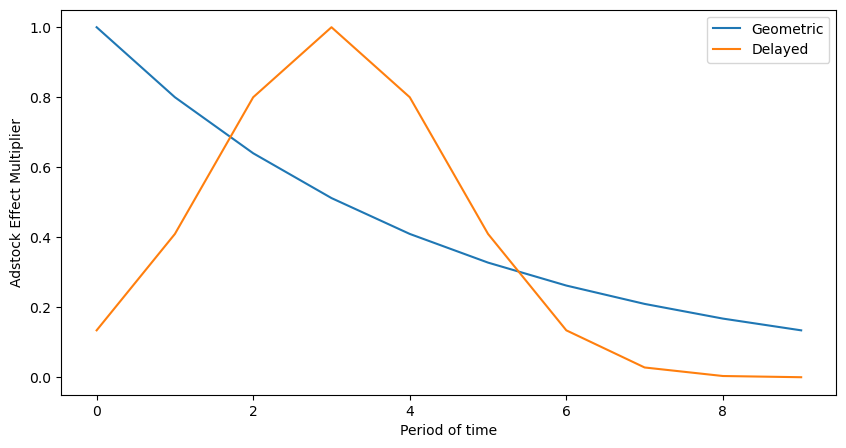

In [2]:
# check plot to see the behavior of the two different functions

plt.figure(figsize=(10,5))

plt.plot(np.arange(0,10,1), adstock_geo(alpha, L), label='Geometric')           # plot the geometric line
plt.plot(np.arange(0,10,1), adstock_delayed(alpha, theta, L), label='Delayed')  # and delayed at the same plot to see the difference
plt.xlabel('Period of time')
plt.ylabel('Adstock Effect Multiplier')
plt.legend()

plt.show()

## Shape effect / Diminishing return

- This situation arises because the effectiveness of the media does not correlate linearly with the sales volume. 
- As previously mentioned, there may be a saturation point where the advertising expenditure is so high that it no longer increases effectiveness. 
- To address this, we consider the **Hill function**. Please refer to the paper for the complete formula. After calculating the Hill function value, we can **multiply it by the regression coefficient**.

We can simply write the mathematical notation of transforming beta using Hill function by:

$\beta - \frac{K^S \cdot \beta}{x^S + K^S}$

Next, we can define a Python function and visualize it as shown below:

In [3]:
def beta_hill(x, S, K, beta):
    '''
    x = media spend
    S = slope where S > 0
    K = half saturation point where K > 0
    beta = regression coefficient for channel where beta > 0
    '''
    return beta - (K ** S * beta) / (x ** S + K ** S)

In [4]:
# create space for x, by plotting x from 0 - 1.5
x = np.linspace(0, 1.5, 100)

# create parameter space, to learn different between each parameter we set
params = {
    'params_1': [0.5, 1, 0.3, 'K = 0.5, S = 1, Beta = 0.3'],
    'params_2': [0.95, 0.748, 0.3925, 'K = 0.95, S = 0.748, Beta = 0.3925'],
    'params_3': [0.5, 2, 0.3, 'K = 0.5, S = 2, Beta = 0.3'],
    'params_4': [0.5, 0.5, 0.3, 'K = 0.5, S = 0.5, Beta = 0.3'],
    'params_5': [1.5, 2, 0.8, 'K = 1.5, S = 2, Beta = 0.8'],
    'params_6': [2, 1.867, 1.144, 'K = 2, S = 1.867, Beta = 1.144']
}

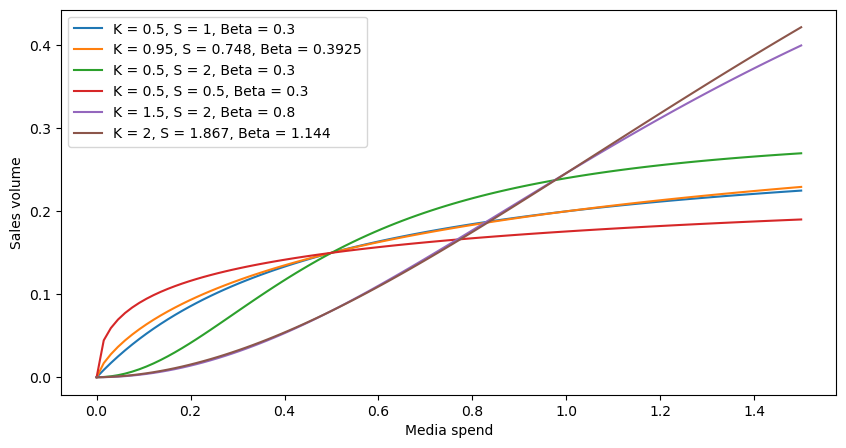

In [5]:
plt.figure(figsize=(10,5))

for i in params.keys():
    # iterating all the parameter space we have
    # and plot it to make comparison between each parameter
    S = params[i][1]
    K = params[i][0]
    beta = params[i][2]
    label = params[i][3]
    
    # pass all the parameters to beta_hill function, and plot it
    y = beta_hill(x, S, K, beta)
    plt.plot(x, y, label=label)

plt.xlabel('Media spend')
plt.ylabel('Sales volume')

plt.legend()
plt.show()

### Notes!

- Take a look at the various parameteres we can pass, that result in many different lines.
- Hill function has a poor identifiability, in the sense that it's quite hard to uniquely determine the parameters of a model from the available data. 
- For instance, take a look at the blue line. It hasn't begun to level off because of diminishing returns, making it impossible for our model to determine the correct value.
- Consequently, the model might erroneously predict high returns as media spending continues to rise.

## Combining carry over + shape effect

Two ways we can do:

### Adstock transformation -> Shape transformation
- When the media expenditure in **each time interval is relatively minor in comparison to the total spending over several intervals**.
- The impact on shape within individual intervals becomes less apparent compared to the cumulative effect of media spending.

### Shape transformation -> Adstock transformation (vice-versa)
- Media expenditure is **heavily concentrated in certain single time period**, displaying a pattern of sporadic activity.

## Simulation

Next, we will test the model using a synthesized data using a simulation. With this, we would be able to know whether the model works or not. Before moving on, we have to know first about **sinusoidal pattern** and **autoregressive integrated moving average (arima) model**, which will be explained below.

### Sinusoidal Pattern

- A sinusoidal pattern is a waveform that oscillates (moves back and forth) between two values sinusoidally, following the shape of a sine wave. 
- In mathematics, a sine wave is a continuous wave that oscillates periodically. 
- It is characterized by its amplitude (the height of the wave), frequency (the number of oscillations per unit of time), and phase (the position of the wave relative to a reference point). 
- The **sine function has a period of 2π**, meaning it completes one full cycle from 0 to 2π.

In the context of the code below, the sinusoidal pattern is used to simulate seasonality in the sales data, where the sales values oscillate in a smooth, wave-like manner over time.

### Autoregressive Integrated Moving Average (ARIMA)

It is a popular time series forecasting model that combines the concepts of autoregression (AR), differencing (I), and moving average (MA) models

- Autoregressive (AR) Model: The AR part of ARIMA models the relationship between the current observation and a number of lagged observations (i.e., previous time steps). 
- Integrated (I) Component: The integrated component represents the differencing of the time series data to make it stationary, i.e., to remove trends and seasonality. 
- Moving Average (MA) Model: The MA part of ARIMA models the relationship between the current observation and a number of lagged forecast errors (i.e., the difference between the predicted and actual values).

### Simulated Data Specification

The paper also shows all the parameters to be set for the data simulation. It includes:

- Two years of sales data (n = 51 * 2 = 102)
- Three media channels
    - media_1: alpha = 0.6, theta = 5, K = 2, S = 1, beta = 0.8
    - media_2: alpha = 0.8, theta = 3, K = 0.2, S = 2, beta = 0.6
    - media_3: alpha = 0.8, theta = 4, K = 0.2, S = 2, beta = 0.3
- Media spend is generated by adding white noise to a sinusoidal seasonality with one year as a period
- One control variable (Price)
- Price is generated via an AR(1) series
- Other variables such as:
    - L = 13
    - ru = 4
    - lambda = -0.5
    - error = normal(0, 0.05 ^ 2)

## Data Generation

In [58]:
# MEDIA CHANNELS VARIABLE

# number of data points, representing of 2 years
# assuming 51 weeks per year for simplicity (2 * 51 = 102)
n = 102

# time variable representing four years (0 to 4π)
# by using 6π, we ensure that the sine wave completes three full cycles over the two-year period
t = np.linspace(0, 4 * np.pi, n)

# generate sales data (y) with seasonality and noise
# - np.sin(t + 0.001): creates a seasonal pattern with a period of one year
# - add constant and an offset (+3 and +0.5) to the sine wave to make it more realistic.
# - np.random.randn(n) add white noise to the data to simulate variability
data = 3 + np.sin(t + 0.001) + 0.5 + np.random.randn(n)

# normalizing of [0, 1] to simulate media spend
media_1 = ((data - min(data)) / max(data) - min(data))

# generate data for media 2 and 3
# have to call data variable again to generate new data
data = 3 + np.sin(t + 0.001) + 0.5 + np.random.randn(n)
media_2 = ((data - min(data)) / max(data) - min(data))

data = 3 + np.sin(t + 0.001) + 0.5 + np.random.randn(n)
media_3 = ((data - min(data)) / max(data) - min(data))

In [59]:
# PRICE VARIABLE

from statsmodels.tsa import arima_process

# setting ar_params, on how the x(t) is influenced by x(t-1) and x(t-2) (weight)
# below, x(t) is influenced 70% by x(t-1) and 60% by x(t-2)
ar_params = np.array([0.7, 0.6])

# setting ma_params, on how the x(t) is influenced by forecast errors (e) in the ARIMA model
# below, x(t) is influenced 20% by e(t-1) and 5% by e(t-2)
ma_params = np.array([0.1, 0.02])

# concatenate the coefficient arrays with a leading 1 to represent the coefficient for the zero-lag term
ar = np.r_[1, ar_params]
ma = np.r_[1, ma_params]

# generate sample based on ar and ma parameters we set before
price_var = arima_process.arma_generate_sample(ar, ma, n)

In [60]:
# MODEL SPECIFICATION

alpha_media_1 = 0.6
theta_media_1 = 5
k_media_1     = 0.2
s_media_1     = 1
beta_media_1  = 0.8

alpha_media_2 = 0.8
theta_media_2 = 3
k_media_2     = 0.2
s_media_2     = 2
beta_media_2  = 0.6
 
alpha_media_3 = 0.8
theta_media_3 = 4
k_media_3     = 0.2
s_media_3     = 2
beta_media_3  = 0.3

# now apply the transformation to the media spending variable using carryover first, then shape effect (hill function) after that

m1 = [beta_hill(x, s_media_1, k_media_1, beta_media_1) for x in effect_carryover(media_1, alpha_media_1, L, theta = theta_media_1, func='delayed')]
m2 = [beta_hill(x, s_media_2, k_media_2, beta_media_2) for x in effect_carryover(media_2, alpha_media_2, L, theta = theta_media_2, func='delayed')]
m3 = [beta_hill(x, s_media_3, k_media_3, beta_media_3) for x in effect_carryover(media_3, alpha_media_3, L, theta = theta_media_3, func='delayed')]

# set all the parameters for the sales data generation
# then generate sales data from all media channels + control of price variable

L = 13
ru = 4
lamb = -0.5
ep = 0.05 ** 2

y = np.repeat(ru, n) + m1 + m2 + m3 + (lamb * price_var) + np.random.normal(0, ep, n)

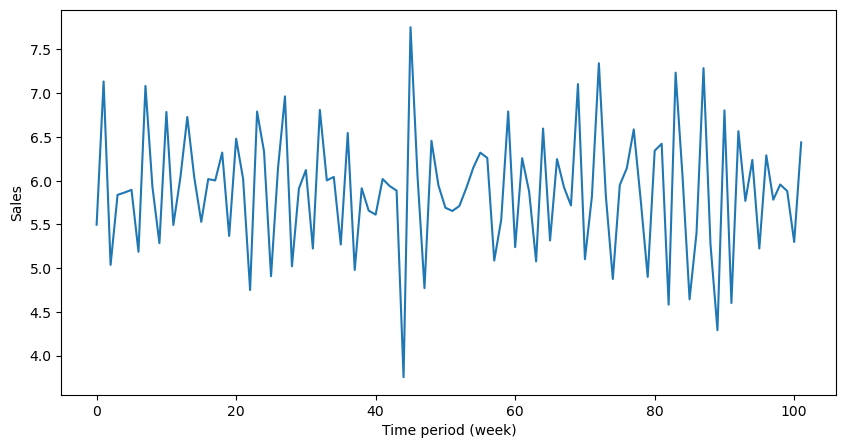

In [61]:
# PLOT THE GENERATED SALES DATA OVER THE TIME

plt.figure(figsize=(10,5))

plt.plot(y)
plt.xlabel('Time period (week)')
plt.ylabel('Sales')

plt.show()

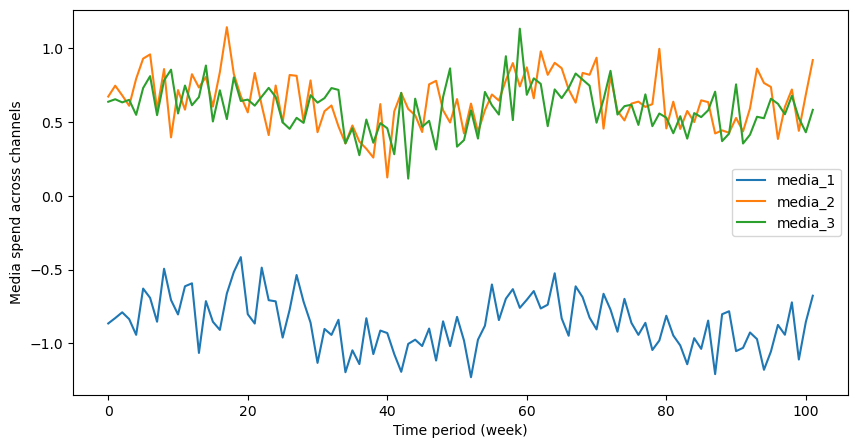

In [64]:
# PLOT THE MEDIA SPEND OVER THE TIME

plt.figure(figsize=(10,5))

label_num = 0

for i in [media_1, media_2, media_3]:
    label_num += 1
    plt.plot(i, label=str(f'media_{label_num}'))

plt.xlabel('Time period (week)')
plt.ylabel('Media spend across channels')
plt.legend()

plt.show()

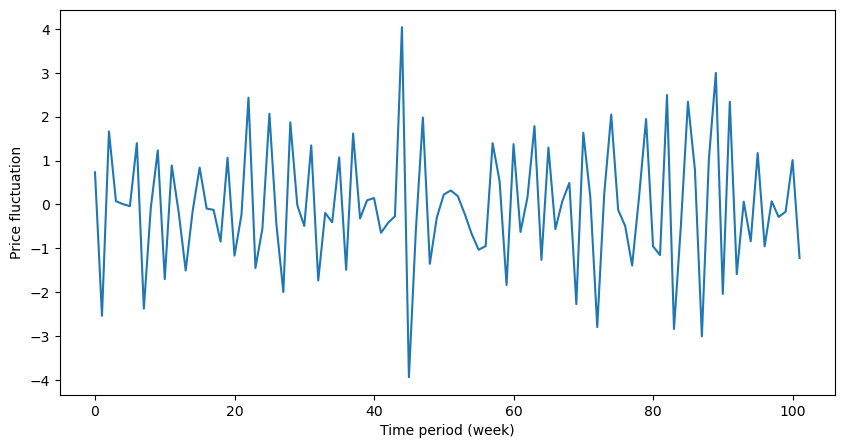

In [65]:
# PLOT PRICE VARIABLE OVER THE TIME

plt.figure(figsize=(10,5))

plt.plot(price_var)
plt.xlabel('Time period (week)')
plt.ylabel('Price fluctuation')

plt.show()

## Model Fitting

- Due to the large number of parameters to be predicted, the author employed a Bayesian approach to fit the model. 
- Please be aware that the model provided below may take a considerable amount of time to complete. It is intended as a reference for you.

In [111]:
import arviz as az
import pymc3 as pm

n_media = 3

with pm.Model() as m:
    
    # specify all the coefficient variables here
    # the format would be "pm." + "{distribution shape of the data}"
    # the number inside is the parameter for the distribution
    # specify shape=n_media in alpha, theta, k, s, and beta to create array of n_media elements for each media

    alpha = pm.Beta('alpha', 3, 3, shape=n_media)
    theta = pm.Uniform('theta', 0, 12, shape=n_media)
    k = pm.Beta('k', 2, 2, shape=n_media)
    s = pm.Gamma('s', 3, 1, shape=n_media)
    beta = pm.HalfNormal('beta', 1, shape=n_media)

    # scalar variables, meaning they are not specific to different media channels
    # these parameters are intended to be shared across all media channels in the model

    ru = pm.HalfNormal('intercept', 5)
    lamb = pm.Normal('lamb', 0, 1)
    noise = pm.InverseGamma('noise', 0.05, 0.0005)

    # transform all media effects using the carryover + beta_hill function
    # by also passing each media spend value to carryover + beta_hill function
    
    transpose_m1 = [beta_hill(x, s[0], k[0], beta[0]) for x in effect_carryover(media_1, alpha[0], L, theta=theta[0], func='delayed')]
    transpose_m2 = [beta_hill(x, s[1], k[1], beta[1]) for x in effect_carryover(media_2, alpha[1], L, theta=theta[1], func='delayed')]
    transpose_m3 = [beta_hill(x, s[2], k[2], beta[2]) for x in effect_carryover(media_3, alpha[2], L, theta=theta[2], func='delayed')]

    # combine everything to get the y_hat (y prediction)
    # defining the observed variable y_hat as a Normal-distributed random variable with mean = ru + transpose_m1 + transpose_m2 + transpose_m3 + transpose_m4 + lamb * price_var 
    # and standard deviation noise
    # where y is the observed data, pass the sales data we have

    y_hat = pm.Normal('y_hat', 
                      mu = ru + transpose_m1 + transpose_m2 + transpose_m3 + lamb * price_var,
                      sigma=noise, 
                      observed=y)

    # fit the data using pm.fit

    trace = pm.fit(method='svgd')

FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `noise_log__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[0] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[1] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `theta_interval__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[0] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[1] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `k_logodds__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[0] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[1] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `s_log__`.ravel()[2] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `intercept_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[0] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[1] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `beta_log__`.ravel()[2] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `lamb`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[0] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[1] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.
The current approximation of RV `alpha_logodds__`.ravel()[2] is NaN.

## Simulating Return on Ad Spend (ROAS)

In addition to parameter estimates, marketing mix model are interested in attribution metrics such as Return on Ad Spend (ROAS) and marginal ROAS (mROAS). While an overall ROAS and mROAS can be calculated across all media spend, there is greater interest in the ROAS and mROAS per channel. These channel-specific metrics help guide the optimization of the media mix.

- **ROAS:** Represents the change in revenue (or sales) per dollar spent on a particular medium. 
- **mROAS:** Additional revenue generated by a one-unit increase in spend, typically from the current spent level.

The paper also shows the calculation on how to do it.

![image.png](images/graph_roas-mroas.png)

*Illustration of ROAS calculation for one media channel taking into account carryover effect. Black lines are predicted weekly sales, and blue lines are scaled spend in the channel. Solid lines are from historical spend, while dashed lines are generated by setting the spend in the change period to zero.*

**Formula**

$
\begin{aligned}
ROAS_m = \frac{\sum_{t_0 \leq t \leq t_1} \hat{Y}_t^m(x_{t-L+1,m}, \dots, x_{t,m}; \Phi) - \hat{Y}_t^m(\overset{\sim}x_{t-L+1,m}, \dots, \overset{\sim}x_{t,m};\Phi)}{\sum_{t_0 \leq t \leq t_1}x_{t,m}} \\
mROAS_m = \frac{\sum_{t_0 \leq t \leq t_1} \hat{Y}_t^m(\overset{\sim}{\overset{\sim}{x}}_{t-L+1,m}, \dots, x_{t,m}; \Phi) - \hat{Y}_t^m(x_{t-L+1,m}, \dots, \overset{\sim}x_{t,m};\Phi)}{0.01 * \sum_{t_0 \leq t \leq t_1}x_{t,m}} \\
\end{aligned}
$

where
- $\hat{Y}_t$ : predicted sales, which depends on media X, control variables Z and parameters Φ.
- $m$ : m-th media channel
- $X_{t,m}$ : historical spend on the m-th channel (blue solid line)
- $\overset{\sim}x_{t,m}$ : spend change (blue dashed line)
- $t_0, t_1$ : change period
- $\hat{Y}_t^m(x_{t-L+1,m}, \dots, x_{t,m}; \Phi)$ : predicted sales using historical spend (black solid line)
- $\hat{Y}_t^m(x_{t-L+1,m}, \dots, \overset{\sim}x_{t,m};\Phi)$ : predicted sales if the spend in the change period is set to zero

and for mROAS
- $\overset{\sim}{\overset{\sim}{x}}_{t,m}$ = same time series of spend as $x_{t,m}$ but increasing the spend in the change period by 1%.

In [ ]:
# simulate ROAS 

# initialize empty lists media_1_roas, media_2_roas, and media_3_roas to store the ROAS values for each media channel.
media_1_roas = []
media_2_roas = []
media_3_roas = []
burnin = 500

for i in range(1000):
    burnin=5
    s = np.random.randint(1,1000-burnin)
    intercept = t['intercept'][s]
    
    s_sample1, s_sample2, s_sample3 = t['s'][:,0][burnin:][s], t['s'][:,1][burnin:][s], t['s'][:,2][burnin:][s]
    k_sample1, k_sample2, k_sample3 = t['k'][:,0][burnin:][s], t['k'][:,1][burnin:][s], t['k'][:,2][burnin:][s]
    b_sample1, b_sample2, b_sample3 = t['beta'][:,0][burnin:][s], t['beta'][:,1][burnin:][s], t['beta'][:,2][burnin:][s]
   
    a_sample1, a_sample2, a_sample3 = t['alpha'][:,0][burnin:][s], t['alpha'][:,1][burnin:][s], t['alpha'][:,2][burnin:][s]
    t_sample1, t_sample2, t_sample3 = t['theta'][:,0][burnin:][s], t['theta'][:,1][burnin:][s], t['theta'][:,2][burnin:][s]
   
    fitted_m1 = [beta_hill(x, s_sample1, k_sample1, b_sample1) for x in effect_carryover(media_1, a_sample1, L, theta = t_sample1, func='delayed')]
    fitted_m2 = [beta_hill(x, s_sample2, k_sample2, b_sample2) for x in effect_carryover(media_2, a_sample2, L, theta = t_sample2, func='delayed')]
    fitted_m3 = [beta_hill(x, s_sample3, k_sample3, b_sample3) for x in effect_carryover(media_3, a_sample3, L, theta = t_sample3, func='delayed')]
 
    y_hat    = intercept + fitted_m1 + fitted_m2 + fitted_m3 + t['lamb'][burnin:][s] * price_var
     
    y_hat_m1 = intercept + fitted_m2 + fitted_m3 + t['lamb'][burnin:][s] * price_var
    y_hat_m2 = intercept + fitted_m1 + fitted_m3 + t['lamb'][burnin:][s] * price_var
    y_hat_m3 = intercept + fitted_m1 + fitted_m2 + t['lamb'][burnin:][s] * price_var
    
    media_1_roas.append(sum(y_hat[L:]-y_hat_m1[L:]) / media_1[L:len(media_1)-L].sum())
    media_2_roas.append(sum(y_hat[L:]-y_hat_m2[L:]) / media_2[L:len(media_1)-L].sum())
    media_3_roas.append(sum(y_hat[L:]-y_hat_m3[L:]) / media_3[L:len(media_1)-L].sum())

## Optimal Media Mix

- Media mix models are additionally utilized to determine the best combination of media channels that maximizes revenue within a specified budget and time frame.
- Suppose the total budget of all media in the change period (t0, t1) is C. The optimal media mix for this period, denoted as Xo = {xot,m, t0 ≤ t ≤ t1, 1 ≤ m ≤ M}, is obtained by...

$
\begin{aligned}
\text{maximize} & \sum_{t_0 \leq t \leq t_1 + L - 1} Y_t(x_{t - L + 1,m}, ..., x_{t,m}; 1 < m < M;\Phi) \\
\text{subject to} & \sum_{t_0 \leq t \leq t_1} \sum_{1\leq m < M} X_{t,m} = C.
\end{aligned}
$

where

- $C$ = total budget of all media in the change period ($t_0$, $t_1$) / budget constrain

# All-in-all

This notebook provides a brief overview of the paper. For a deeper understanding of the underlying mechanism, I recommend reviewing the full paper by Jin et al.